## Aliens vs Predators - Snowboarders vs Skiers.

### Stage 1:
Generate biased dataset of a ski condo loan. The loans targets decisions for skiers and snowboarders.
On average, it has more data on aliens than on predators.
On average, snowboarders pay back historic loans at higher rates than skiers.
This bias is simulated in the data

Note: The above assumption is that this is bias, it might not be, it can be simply the case that aliens are better than predators, but we assume that this is bias in the data and we try to eliminate.

In [476]:
import numpy as np
import pandas as pd
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [477]:
race_choices = ['Alien', 'Predator', 'N/A']
race_probs = [0.8, 0.1, 0.1]
num_samples=10000
num_samples_unbiased=5000

def biased_credit_score(row, not_biased=False):
    if row['Race'] == 'Alien' and row['Type'] == 'Snowboarder' and not not_biased:
        return np.random.normal(loc=750, scale=50)
    else:
        return np.random.normal(loc=650, scale=50)
    
def biased_repayment_rate(row, not_biased=False):
    if row['Race'] == 'Alien' and row['Type'] == 'Snowboarder' and not not_biased:
        return np.random.choice([0, 1], p=[0.2, 0.8]) # biased towards snowboarder
    else:
        return np.random.choice([0, 1], p=[0.4, 0.6])

biased_data = {
    'Race': np.random.choice(race_choices, num_samples, p=race_probs),
    'Type': np.random.choice(['Skier', 'Snowboarder'], num_samples)
}

unbiased_data = {
    'Race': np.random.choice(race_choices, num_samples_unbiased, p=[1/3, 1/3, 1/3]),
    'Type': np.random.choice(['Skier', 'Snowboarder'], num_samples_unbiased)
}

biased_df = pd.DataFrame(biased_data)
biased_df['Credit_Score'] = biased_df.apply(biased_credit_score, axis=1).astype(int)
biased_df['Repayment_Rate'] = biased_df.apply(biased_repayment_rate, axis=1)

biased_df['Credit_Score'] = biased_df['Credit_Score'].clip(lower=300, upper=850)

unbiased_df = pd.DataFrame(unbiased_data)
unbiased_df['Credit_Score'] = unbiased_df.apply(biased_credit_score, axis=1, args=(True,)).astype(int)
unbiased_df['Repayment_Rate'] = unbiased_df.apply(biased_repayment_rate, args=(True,), axis=1)

unbiased_df['Credit_Score'] = unbiased_df['Credit_Score'].clip(lower=300, upper=850)


# target
biased_df['Loan_Repayment'] = ((biased_df['Credit_Score'] > 700) & (biased_df['Repayment_Rate'] == 1)).astype(int)
unbiased_df['Loan_Repayment'] = ((unbiased_df['Credit_Score'] > 650) & (unbiased_df['Repayment_Rate'] == 1)).astype(int)

biased_df['Stratify_Key'] = biased_df['Race'] + "_" + biased_df['Type']
unbiased_df['Stratify_Key'] = unbiased_df['Race'] + "_" + unbiased_df['Type']

biased_df.head()

,Race,Type,Credit_Score,Repayment_Rate,Loan_Repayment,Stratify_Key
0,Alien,Snowboarder,651,1,0,Alien_Snowboarder
1,Alien,Snowboarder,769,1,1,Alien_Snowboarder
2,Alien,Snowboarder,755,1,1,Alien_Snowboarder
3,Alien,Snowboarder,790,1,1,Alien_Snowboarder
4,Alien,Snowboarder,763,1,1,Alien_Snowboarder


#### Step 2 - Develop algorithm with statistical parity on blind attributes
Decide on blind attribute model: credit score + historic loan repayment rate<br />
Decide method of fairness: equality of false negatives<br />
Select training data that equally represents all groups as evenly as possible<br />

In [478]:
biased_stratify_key = biased_df['Stratify_Key']
unbiased_stratify_key = unbiased_df['Stratify_Key']

# Manually balance the group by sampling them at the same frequency
min_group_size = biased_df['Stratify_Key'].value_counts().min()
balanced_df = pd.DataFrame()

for group in biased_df['Stratify_Key'].unique():
    group_subset = biased_df[biased_df['Stratify_Key'] == group]
    sampled_subset = group_subset.sample(n=min_group_size, random_state=42)
    balanced_df = pd.concat([balanced_df, sampled_subset], axis=0)

X_train = balanced_df[['Credit_Score', 'Repayment_Rate']]
Y_train = balanced_df['Loan_Repayment']

X_test = biased_df[['Credit_Score', 'Repayment_Rate']].copy()
Y_test = biased_df['Loan_Repayment']

In [479]:
# Train a logistic regression model focusing on credit score and historic loan repayment rate as features
# This is a blind classifier, without any fairness
loanClassifier_without_fairness = LogisticRegression(random_state=0).fit(X_train, Y_train)

In [480]:
# print the score on the test set - remember the test set is biased as well in this case, because it's a historical test set
print(loanClassifier_without_fairness.score(X_test, Y_test))
Y_pred = loanClassifier_without_fairness.predict(X_test)

0.9851


In [481]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[6595   78]
 [  71 3256]]


In [482]:
def plot_cm(cm):
    classes = ['denied', 'accepted']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

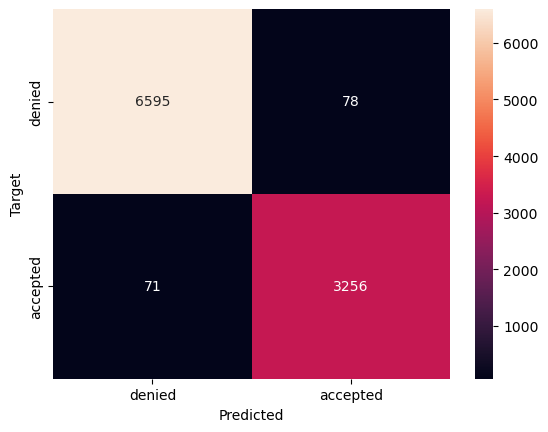

In [483]:
plot_cm(cm)

In [484]:
def calculate_group_fnr(X_test, Y_test, Y_pred):
    group_fnr = {}
    
    for group in X_test['Stratify_Key'].unique():
        # Get indices for the current group based on Stratify_Key
        group_indices = X_test[X_test['Stratify_Key'] == group].index
        
        # Calculate confusion matrix for the group
        cm = confusion_matrix(Y_test.loc[group_indices], Y_pred[group_indices])
        TN, FP, FN, TP = cm.ravel()
        
        # Calculate FNR = FN / (FN + TP)
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
        group_fnr[group] = fnr
    
    return group_fnr

In [485]:
X_test['Stratify_Key'] = biased_df['Stratify_Key']
group_fnr_biased = calculate_group_fnr(X_test, Y_test, Y_pred)
sorted_group_fnr_biased = sorted(group_fnr_biased.items(), key=lambda item: -item[1])
print(f"Group false negative rates are:")
print("")
for key, value in sorted_group_fnr_biased:
    print(f"{key}: {value:.2f}")

Group false negative rates are:

Predator_Snowboarder: 0.12
N/A_Skier: 0.07
N/A_Snowboarder: 0.05
Alien_Skier: 0.04
Predator_Skier: 0.04
Alien_Snowboarder: 0.02


#### Conclusion:
We can see from the above that the model favours alien snowboarders despite equally including all groups. And this makes sense since the model itself is as good as its data

#### Step 3 - Develop algorithm for subgroup fairness including type, race, credit score, repayment rates
Decide protected attribute model: type, race, credit score, repayment rates<br />
Feed protected attributes into a subgroup fairness model and figure out which is the best point to have equality of false negatives<br />
Select training data that equally represents all groups as evenly as possible<br />